## MalConv2 Model Execution
This section demonstrates how to load and run the MalConv2 model using the instructions and files from the `MalConv2-main` directory. Code is based on the README instructions.

In [4]:
import sys
import os
import torch
import numpy as np
import torch.nn.functional as F

# 경로 설정 유연성 확보 (Notebook 실행 위치에 따라 경로가 다를 수 있음)
# MalConv2-main 폴더 찾기
current_dir = os.getcwd()
possible_paths = [
    os.path.join(current_dir, 'MalConv2-main'),         # 작업 설정이 루트일 경우
    os.path.join(current_dir, '../models/MalConv2-main'),      # 작업 설정이 현재 파일 위치(test/)일 경우
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main' # 절대 경로 (fallback)
]

malconv_path = None
for p in possible_paths:
    if os.path.exists(p) and os.path.isdir(p):
        malconv_path = os.path.abspath(p)
        break

if malconv_path:
    if malconv_path not in sys.path:
        sys.path.append(malconv_path)
    print(f"MalConv2-main path added: {malconv_path}")
else:
    print("Error: Could not find MalConv2-main directory.")

# src 폴더 경로 추가 (preprocess.py 사용을 위해)
src_path = os.path.abspath(os.path.join(current_dir, '../'))
if src_path not in sys.path:
    sys.path.append(src_path)

try:
    # MalConvGCT 및 전처리 함수 임포트
    from MalConvGCT_nocat import MalConvGCT
    from src import preprocess_pe_file
    print("Successfully imported MalConvGCT and preprocess_pe_file")

    # 모델 초기화 (README의 파라미터 참고)
    # channels=256, window_size=256, stride=64 설정
    channels = 256
    window_size = 256
    stride = 64
    embd_size = 8
    
    print("Initializing model...")
    model = MalConvGCT(out_size=2, channels=channels, window_size=window_size, stride=stride, embd_size=embd_size)
    
    # 체크포인트 로드
    checkpoint_path = os.path.join(malconv_path, 'malconvGCT_nocat.checkpoint')
    
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}...")
        # Mac M2(Apple Silicon) 호환성을 위해 map_location='cpu' 사용 권장
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        
        # 가중치 로드
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'], strict=False)
            print("Model weights loaded successfully.")
        else:
            print(f"Warning: 'model_state_dict' not found. Keys: {checkpoint.keys()}")
    else:
        print(f"Warning: Checkpoint file not found at {checkpoint_path}. Running with random weights.")

    # 모델을 평가 모드로 설정
    model.eval()

    # 실제 파일 전처리 및 실행 테스트
    target_file = 'ZoomInstaller.exe'
    
    # 파일 존재 여부 확인 후 진행
    if os.path.exists(target_file):
        print(f"Processing file: {target_file}")
        
        # preprocess_pe_file 함수를 사용하여 입력 데이터 준비
        # mode='default' 사용
        input_tensor = preprocess_pe_file(target_file, mode='default')
        
        print(f"Running inference on input with shape {input_tensor.shape}...")
        
        with torch.no_grad():
            output = model(input_tensor)
            # MalConvGCT returns: (logits, penult, post_conv)
            logits = output[0]
            probabilities = F.softmax(logits, dim=1)
            
        print("\nExecution Complete!")
        print(f"Logits: {logits}")
        
        # 결과 해석
        print("\n[결과 해석]")
        print(f"1. Logits (Raw Score): {logits.tolist()}")
        print(f"2. Probabilities (Softmax): {probabilities.tolist()}")
        print(f"   - Class 0 (Benign/정상): {probabilities[0][0].item():.4f} ({probabilities[0][0].item()*100:.2f}%)")
        print(f"   - Class 1 (Malware/악성): {probabilities[0][1].item():.4f} ({probabilities[0][1].item()*100:.2f}%)")
        
        predicted_class = torch.argmax(probabilities, dim=1).item()
        class_label = "악성 (Malware)" if predicted_class == 1 else "정상 (Benign)"
        print(f"3. 최종 예측: {class_label} (Class {predicted_class})")
        
    else:
        print(f"Error: Target file '{target_file}' not found. Please make sure the file exists in the current directory.")

except ImportError as e:
    print(f"Import Error: {e}")
    print("Make sure MalConv2-main is in the path and src package is accessible.")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

MalConv2-main path added: /Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main
Successfully imported MalConvGCT and preprocess_pe_file
Initializing model...
Loading checkpoint from /Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main/malconvGCT_nocat.checkpoint...
Model weights loaded successfully.
Processing file: ZoomInstaller.exe
Running inference on input with shape torch.Size([1, 4000000])...

Execution Complete!
Logits: tensor([[ 2.7693, -5.6580]])

[결과 해석]
1. Logits (Raw Score): [[2.769256591796875, -5.658012866973877]]
2. Probabilities (Softmax): [[0.9997811913490295, 0.0002187703939853236]]
   - Class 0 (Benign/정상): 0.9998 (99.98%)
   - Class 1 (Malware/악성): 0.0002 (0.02%)
3. 최종 예측: 정상 (Benign) (Class 0)


In [2]:
# Config 로드 테스트
from src.utils import load_config
try:
    config = load_config()
    print("Config loaded successfully:")
    print(config)
except Exception as e:
    print(f"Failed to load config: {e}")

Config loaded successfully:
{'model': {'malconv': {'channels': 256, 'window_size': 256, 'stride': 64, 'embd_size': 8, 'num_classes': 2}}, 'attack': {'padding_ratio': 0.01, 'iterations': 20}, 'explainability': {'deep_shap': {'baseline': 'zero', 'approximation': True}}}



--- Testing MalConvGCTDeepShap ---
Model path found: /Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main
Initializing MalConvGCTDeepShap model...
Loading checkpoint from: /Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main/malconvGCT_nocat.checkpoint
Checkpoint loaded successfully.
Loading target file: ZoomInstaller.exe
Input loaded. Shape: torch.Size([1, 4000000])
Executing forward pass (predict + explain)...

[Execution Successful]
Logits: [[ 2.7692566 -5.658013 ]]
Probabilities: [[9.997812e-01 2.187704e-04]]

[SHAP Statistics]
Context SHAP - Max: 0.000000, Min: 0.000000, Sum: 0.000000
Feature SHAP - Max: 0.000000, Min: 0.000000, Sum: 0.000000


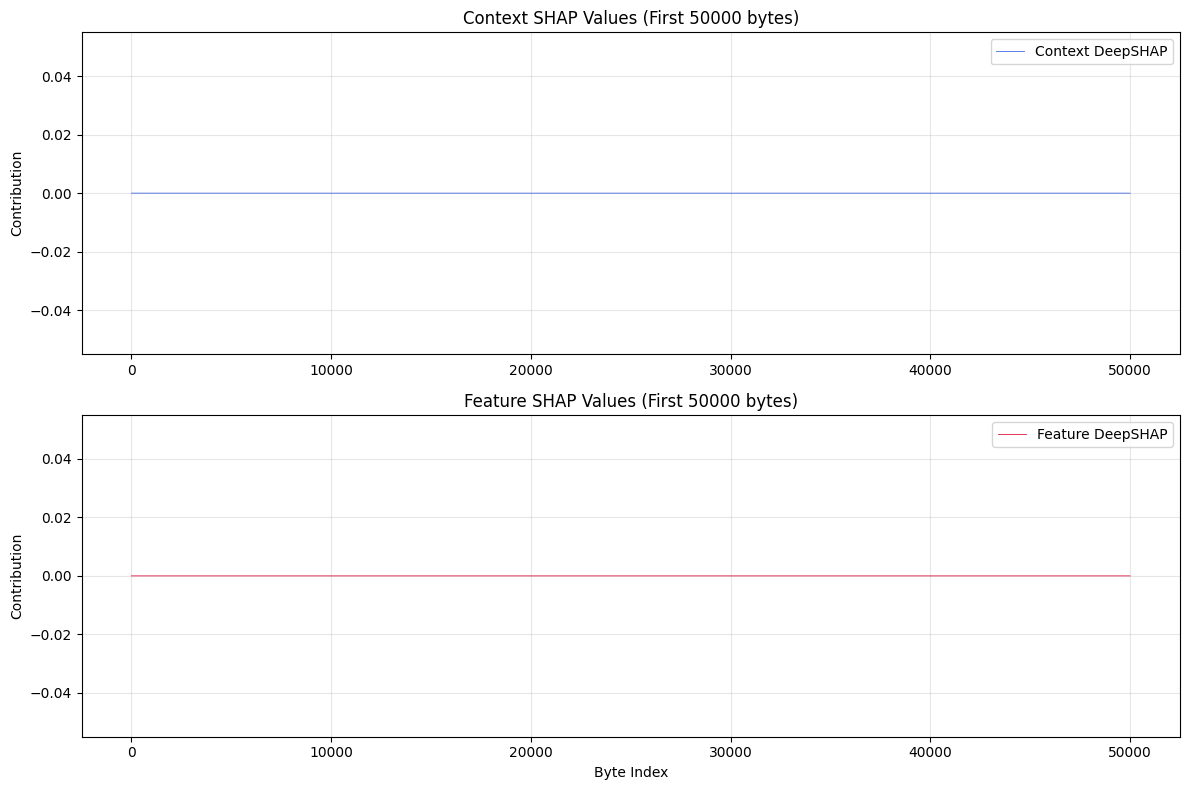

In [3]:
# MalConvGCTDeepShap Class Test
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

print("\n--- Testing MalConvGCTDeepShap ---")

# 1. Path Setup (경로 설정)
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '../'))
if src_path not in sys.path: sys.path.append(src_path)

# MalConv2-main 폴더 찾기
possible_paths = [
    os.path.join(current_dir, '../models/MalConv2-main'),
    os.path.join(current_dir, 'MalConv2-main'),
    '/Users/wjm/Desktop/2026 프로젝트/Binary-Hunter/models/MalConv2-main'
]

malconv_path = None
for p in possible_paths:
    if os.path.exists(p) and os.path.isdir(p):
        malconv_path = os.path.abspath(p)
        break

if malconv_path:
    if malconv_path not in sys.path: sys.path.append(malconv_path)
    print(f"Model path found: {malconv_path}")
else:
    print("Warning: MalConv2-main path not found. Imports might fail.")

# Import modules
from src.compute_DeepShap import MalConvGCTDeepShap
from src import preprocess_pe_file

# 2. Initialize Model (모델 초기화)
# Default parameters as per README/previous cells
channels = 256
window_size = 256
stride = 64
embd_size = 8

print("Initializing MalConvGCTDeepShap model...")
new_model = MalConvGCTDeepShap(out_size=2, channels=channels, window_size=window_size, stride=stride, embd_size=embd_size)

# 3. Load Checkpoint (체크포인트 로드)
# 이전 셀 실행 여부와 관계없이 직접 체크포인트를 로드합니다.
if malconv_path:
    checkpoint_path = os.path.join(malconv_path, 'malconvGCT_nocat.checkpoint')
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from: {checkpoint_path}")
        try:
            # Map location to CPU for compatibility
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            
            if 'model_state_dict' in checkpoint:
                # strict=False allows loading even if some auxiliary keys differ, but usually should match
                new_model.load_state_dict(checkpoint['model_state_dict'], strict=False)
                print("Checkpoint loaded successfully.")
            else:
                 new_model.load_state_dict(checkpoint, strict=False)
                 print("Checkpoint loaded successfully (direct state dict).")
        except Exception as e:
            print(f"Failed to load checkpoint: {e}")
    else:
        print(f"Checkpoint file NOT found at: {checkpoint_path}")
else:
    print("Cannot look for checkpoint because model directory was not found.")

new_model.eval()

# 4. Prepare Input (입력 데이터 준비)
# 파일이 있으면 로드, 없으면 랜덤 (테스트용)
target_file = 'ZoomInstaller.exe'
input_tensor = None

if os.path.exists(target_file):
    print(f"Loading target file: {target_file}")
    try:
        input_tensor = preprocess_pe_file(target_file, mode='default')
        print(f"Input loaded. Shape: {input_tensor.shape}")
    except Exception as e:
        print(f"Error processing file: {e}")
else:
    print(f"Target file '{target_file}' not found.")

if input_tensor is None:
    print("Warning: Using random input tensor (fallback). SHAP values might be zero or meaningless.")
    input_tensor = torch.randint(0, 256, (1, 200000)).long()

# 5. Forward Pass with SHAP
print("Executing forward pass (predict + explain)...")
try:
    # Model returns: (logits, penult, post_conv, shap_context, shap_feature)
    outputs = new_model(input_tensor)
    
    if len(outputs) == 5:
        logits, penult, post_conv, shap_context, shap_feature = outputs
        
        print("\n[Execution Successful]")
        print(f"Logits: {logits.detach().cpu().numpy()}")
        
        # Calculate Probabilities
        probs = torch.nn.functional.softmax(logits, dim=1)
        print(f"Probabilities: {probs.detach().cpu().numpy()}")
        
        # Basic Statistics
        print(f"\n[SHAP Statistics]")
        print(f"Context SHAP - Max: {np.max(shap_context):.6f}, Min: {np.min(shap_context):.6f}, Sum: {np.sum(shap_context):.6f}")
        print(f"Feature SHAP - Max: {np.max(shap_feature):.6f}, Min: {np.min(shap_feature):.6f}, Sum: {np.sum(shap_feature):.6f}")

        # Visualization
        plt.figure(figsize=(12, 8))
        
        # Display first N bytes
        view_len = min(50000, len(shap_context))
        x_axis = range(view_len)
        
        plt.subplot(2, 1, 1)
        plt.plot(x_axis, shap_context[:view_len], label='Context DeepSHAP', color='royalblue', linewidth=0.6)
        plt.title(f'Context SHAP Values (First {view_len} bytes)')
        plt.ylabel('Contribution')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 1, 2)
        plt.plot(x_axis, shap_feature[:view_len], label='Feature DeepSHAP', color='crimson', linewidth=0.6)
        plt.title(f'Feature SHAP Values (First {view_len} bytes)')
        plt.ylabel('Contribution')
        plt.xlabel('Byte Index')
        plt.legend(loc='upper right')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"Unexpected output length: {len(outputs)}. Output structure might have changed.")
        
except Exception as e:
    print(f"Error during execution: {e}")
    import traceback
    traceback.print_exc()
